# 1. Description of the Problem and Discussion of the Background

## (Week 1)

If you are a serious craft beer fan, you know that Seattle has a wide array of breweries to choose from. According to a recent report from SmartAsset 'Best Beer Cities for Drinkers - 2019 Edition', the total number of breweries in Seattle ranks fifth overall in the United States. With so many choices, here lies the problem: how does one decide which breweries to visit for the best craft beer experience? Since choosing where to have a beer is serious business for some, I've narrowed down the must-try spots for you. The findings of this study will be helpful for anyone living, working, or vacationing in the area who would like to enjoy a delicious and unique craft beer from one of the best breweries in Seattle.

# 2. Description of the data and how it will be used to solve the problem

## (Week 1)

1. Retrieve Seattle neighborhoods and geographical coordinates from a CSV file or by web scraping from a website & transform      data into a pandas dataframe.
2. Use Foursquare API to get the brewery venues, caterories, add venue id within a radius of 1000 meters.
3. Clean the venue list to include only venues that are catigorized as a brewery only.
4. Use folium to create a map of Seattle with breweries superimposed on top.
5. Define a function to get details on venue likes, ratings, and tips for each venue id. These will be used to evaluate the        breweries.
6. Merge additional CSV file containing beer and venue ratings from BeerAdvocate into main dataframe.
7. Breweries are now ready to be rated by four factors: beer, place, like counts, and tip counts generated from our searches      and imported files. These factors will then be rescaled with a score between 0 to 10, weighted by relative importance, and      then added up for a final weighted score for each brewery. This method of scoring is known as a decision matrix analysis and    can help customers decide on the best breweries based on multiple factors.
8. Finially, customer reviews and comments will be evaluated from the top five breweries determined from above, and visualized    using word clouds to help gain deeper insights into each breweries specialties, unique characteristics, and vibe.



## Data Acquisition and Cleaning
    
    

### First we import all necessary liberies

In [1]:
import numpy as np 
import pandas as pd 
import json # library to handle JSON files
import requests # library to handle requests

#!conda install -c conda-forge geopy --yes 

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


### Retrieve Seattle neighborhoods from the MADRONA GROUP website  & transform data into a pandas dataframe¶

In [2]:
#scape the wikipedia page for postal code table using pandas

df = pd.read_excel (r'C:/Users/thayes/Documents/GitHub/projects/Coursera_Capstone/Seattle_Neighborhoods.xlsx', sheet_name='Seattle_Neighborhoods')
print(df.shape)

#Show all rows
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(df.count())
df.head()



(55, 1)
Neighborhood    55
dtype: int64


,Neighborhood
0,Belltown
1,Broadmoor
2,Capitol Hill
3,Central District
4,Denny-Blaine


### Load CSV data for geographical coordinates of each postal code and transform into a pandas dataframe

In [3]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="tor_explorer")
geocodes = [geolocator.geocode(df['Neighborhood'][i] + ', Seattle, WA')for i in range(len(df))]


### Add the output latitude and longitude values in the geocodes list to the df dataframe

In [4]:
df['Latitude'] = [g.latitude for g in geocodes]
df['Longitude'] = [g.longitude for g in geocodes]
df.head()

,Neighborhood,Latitude,Longitude
0,Belltown,47.613231,-122.345361
1,Broadmoor,47.635170,-122.289711
2,Capitol Hill,47.623831,-122.318369
3,Central District,47.603110,-122.308270
4,Denny-Blaine,47.622327,-122.285985


### Use geopy library to get the latitude and longitude values of Seattle to create a map

In [5]:
address = 'Seattle, Ontario'

#geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.5678553, -122.3228952.


### Create a map of Seattle with neighborhoods superimposed on top

In [6]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

Next, start utilizing the Foursquare API to explore the neighborhoods and segment them

### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'WTZV250VI2NW2TLTAZXPE0LLBHOZ4ZW1J1FOYMNXZ3ABHWXS' # your Foursquare ID
CLIENT_SECRET = 'DZDI1V5GZTBMR333M20APKIMG2WRIKCYGYE05NSERITQTHAV' # your Foursquare Secret
VERSION = '20210124' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WTZV250VI2NW2TLTAZXPE0LLBHOZ4ZW1J1FOYMNXZ3ABHWXS
CLIENT_SECRET:DZDI1V5GZTBMR333M20APKIMG2WRIKCYGYE05NSERITQTHAV


### Get the brewery venues within a radius of 1000 meters

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL 
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'Brewery'
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])
        
    brewery_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    brewery_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category', 
                  'Venue ID'] 
    
    return(brewery_venues)

### Now write the code to run the above function on each neighborhood and create a new dataframe called _seattle_brewery_venues_

In [9]:
seattle_brewery_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])
#seattle_brewery_venues.shape



Belltown
Broadmoor
Capitol Hill
Central District
Denny-Blaine
Downtown
Eastlake
First Hill
International District
Leschi
Madison Park
Madison Valley
Madrona
Montlake
Pioneer Square
South Lake Union
Bryant
Hawthorne Hills
Lake City
Laurelhurst
Maple Leaf
Matthews Beach
Northgate
Ravenna
Roosevelt
U-District
View Ridge
Wedgwood
Windermere
Ballard
Blue Ridge/North Beach
Broadview
Crown Hill
Fremont
Green Lake
Greenwood
Haller Lake
Loyal Heights
Magnolia
Phinney Ridge
Queen Anne
Wallingford
Westlake
Whittier Heights
Beacon Hill
Columbia City
Georgetown
Mount Baker
Rainier Beach
Seward Park
South Park
Admiral
Alki
Fauntleroy
Junction


### Let's see what the dataframe looks like

In [10]:
print(seattle_brewery_venues.shape)

#pd.set_option("display.max_rows", None, "display.max_columns", None)
seattle_brewery_venues.head()



(113, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Belltown,47.613231,-122.345361,Cloudburst Brewing,47.611565,-122.345212,Brewery,54f8d7cd498e011cb93ae3c9
1,Belltown,47.613231,-122.345361,Old Stove Brewing Co - Marketfront,47.609591,-122.343041,Brewery,595c0cb5123a195de691c5ea
2,Belltown,47.613231,-122.345361,Pike Brewing Company,47.608161,-122.339923,Brewery,40b13b00f964a520e1f61ee3
3,Belltown,47.613231,-122.345361,No Anchor,47.615612,-122.348440,Beer Bar,57def285498ea530e654b0ef
4,Belltown,47.613231,-122.345361,Downtown Spirits,47.617892,-122.341815,Liquor Store,50679a14e4b0890847c12a3f


### Next, clean the venue list to include only venues that are catigorized as a brewery only


In [11]:
#Display rows with the category 'Brewery' only
seattle_brewery_venues_only = seattle_brewery_venues[seattle_brewery_venues['Venue Category'].str.contains('Brewery')]

#Remove any duplicates
seattle_brewery_venues_only.drop_duplicates(subset='Venue ID', keep='first', inplace=True)

#Reset the index
seattle_brewery_venues_only = seattle_brewery_venues_only.reset_index(drop=True)

#Lets see what it looks like
print(seattle_brewery_venues_only.shape)
seattle_brewery_venues_only.head()


(65, 8)


C:\Users\thayes\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Belltown,47.613231,-122.345361,Cloudburst Brewing,47.611565,-122.345212,Brewery,54f8d7cd498e011cb93ae3c9
1,Belltown,47.613231,-122.345361,Old Stove Brewing Co - Marketfront,47.609591,-122.343041,Brewery,595c0cb5123a195de691c5ea
2,Belltown,47.613231,-122.345361,Pike Brewing Company,47.608161,-122.339923,Brewery,40b13b00f964a520e1f61ee3
3,Capitol Hill,47.623831,-122.318369,Outer Planet Craft Brewing,47.618050,-122.316821,Brewery,53c1db29498eabb50501e673
4,Central District,47.603110,-122.308270,Standard Brewing,47.599396,-122.299711,Brewery,5141334ce4b00f63c3fa2085


## Data Visualization

### Create a map of Seattle showing all 65 brewery locations

In [12]:
# create map of Seattle using latitude and longitude values
map_all_breweries = folium.Map(location=[latitude, longitude], zoom_start=10)

# add brewery markers to map
for lat, lng, venue in zip(seattle_brewery_venues_only['Venue Latitude'], seattle_brewery_venues_only['Venue Longitude'], seattle_brewery_venues_only['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all_breweries)  
    
map_all_breweries

### Find the brewery density in each neighborhood

In [13]:
#Sort list by Neighborhoods and count number of venues in each
sort_by_neighborhod = seattle_brewery_venues_only.groupby(['Neighborhood']).count()

#Srt by descending values 
final_venue_count_by_neighborhood = sort_by_neighborhod.sort_values(['Venue'], ascending=[False])

#Lets see what we get
final_venue_count_by_neighborhood = final_venue_count_by_neighborhood[['Venue']]

#Reset the index
brewery_count_per_neighborhood = final_venue_count_by_neighborhood.reset_index()
brewery_count_per_neighborhood.head()

,Neighborhood,Venue
0,Georgetown,6
1,South Park,5
2,Loyal Heights,4
3,Fremont,4
4,Beacon Hill,3


## Data visualizations using bar graphs from matplitlib

### Graph below depicting brewery density within each neighborhood of Seattle. Notice that Georgetown has the most breweries with six, followed by South Park with Five.  So if you want to stay in the same neighborhood and visit as many breweries as possible, then Georhetown or South Park may be the neighborhoods you'd like to explore. 

<BarContainer object of 30 artists>

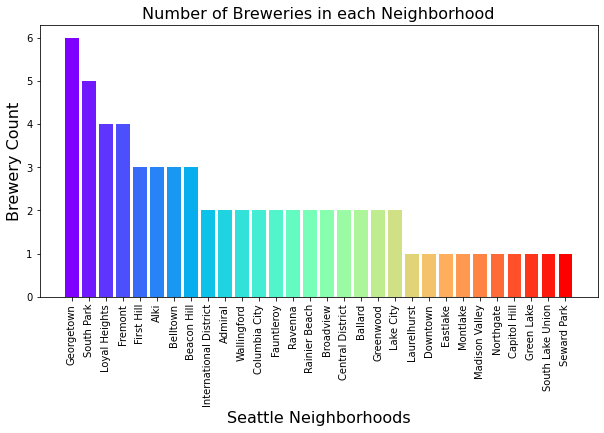

In [14]:
all_venue_dist = seattle_brewery_venues_only['Neighborhood'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(all_venue_dist.index)))
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
plt.xlabel('Seattle Neighborhoods', fontsize = 16)
plt.ylabel('Brewery Count', fontsize = 16)
plt.title('Number of Breweries in each Neighborhood', fontsize = 16)
plt.bar(all_venue_dist.index, all_venue_dist.values, color = colors)

In [15]:
brewery_wa = seattle_brewery_venues_only[['Neighborhood','Venue ID', 'Venue']]
brewery_wa.columns = ['Neighborhood', 'ID', 'Name']
brewery_wa

,Neighborhood,ID,Name
0,Belltown,54f8d7cd498e011cb93ae3c9,Cloudburst Brewing
1,Belltown,595c0cb5123a195de691c5ea,Old Stove Brewing Co - Marketfront
2,Belltown,40b13b00f964a520e1f61ee3,Pike Brewing Company
3,Capitol Hill,53c1db29498eabb50501e673,Outer Planet Craft Brewing
4,Central District,5141334ce4b00f63c3fa2085,Standard Brewing
5,Central District,5fcd70eaa3f7d17c70688864,Sovereign Brewing
6,Downtown,44eb3602f964a520c8371fe3,Elysian Fields
7,Eastlake,4e617515a80951b31815a772,Cow Girls Inc
8,First Hill,596684d82e26801ba35903ca,Redhook Brewlab
9,First Hill,55caba3a498e5e44306adf98,Optimism Brewing Company


### Use Foursquare API to get venue details

In [16]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'WTZV250VI2NW2TLTAZXPE0LLBHOZ4ZW1J1FOYMNXZ3ABHWXS'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='DZDI1V5GZTBMR333M20APKIMG2WRIKCYGYE05NSERITQTHAV' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20210124' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue'] 
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count'] 
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']  #'tips' 'count'
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips'] 
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Lets define a function to get details on venue likes, ratings, and tips for each venue id.  These will be used to evaluate the breweries

In [17]:
# prepare list of breweries and associated likes, ratings and tips
column_names=['Neighborhood','ID','Name','Likes','Rating','Tips'] 
brewery_stats=pd.DataFrame(columns=column_names) 
count=1


for row in brewery_wa.values.tolist():
    Neighborhood,ID,Name=row 
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0] 
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
    #id,name,likes,rating,tips=[0]*5                                           
    print('(',count,'/',len(brewery_wa),')','processed')
    brewery_stats = brewery_stats.append({'Neighborhood': Neighborhood,
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


                         ID                Name  Likes  Rating  Tips
0  54f8d7cd498e011cb93ae3c9  Cloudburst Brewing    199     9.1    36
( 1 / 65 ) processed
                         ID                                Name  Likes  \
0  595c0cb5123a195de691c5ea  Old Stove Brewing Co - Marketfront    117   

   Rating  Tips  
0     8.7    22  
( 2 / 65 ) processed
                         ID                  Name  Likes  Rating  Tips
0  40b13b00f964a520e1f61ee3  Pike Brewing Company    630     8.2   236
( 3 / 65 ) processed
                         ID                        Name  Likes  Rating  Tips
0  53c1db29498eabb50501e673  Outer Planet Craft Brewing     35     7.4     8
( 4 / 65 ) processed
                         ID              Name  Likes  Rating  Tips
0  5141334ce4b00f63c3fa2085  Standard Brewing     48     8.5     7
( 5 / 65 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5fcd70eaa3f7d17c70688864
( 6 / 65 ) processed
   

                         ID             Name  Likes  Rating  Tips
0  52fff4cc11d27cedce1b52fc  Tin Dog Brewing     13     7.5     3
( 54 / 65 ) processed
                         ID             Name  Likes  Rating  Tips
0  523b4e0d11d2ea39626220dc  Burdick Brewery      5     6.6     3
( 55 / 65 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5956c654fc9e9478147a0145
( 56 / 65 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5aece83167e5f2002ca9bb00
( 57 / 65 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4be99acaf90e9c743950e3ed
( 58 / 65 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5e402e63228e4400081e4272
( 59 / 65 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 52894eeb498e0e70cdae15c5
( 60 / 65 ) pr

### Complete additional data cleaning to remove duplicate rows and venues that are not breweries

In [18]:
# delete all rows with column 'Name' has value 0 
indexNames = brewery_stats[(brewery_stats['Name'] == 0)].index
brewery_stats.drop(indexNames, inplace=True)

#Remove any duplicates
brewery_stats.drop_duplicates(subset='ID', keep='first', inplace=True)

In [19]:
brewery_stats.reset_index(inplace=True)

brewery_stats = brewery_stats[['Neighborhood','ID', 'Name', 'Likes', 'Rating', 'Tips']]


### Lets extract venue lat and long values from prior table (seattle_brewing_venues_only) and combine with our brewery stats (brewery_stats)

In [20]:

venue_lat_long = seattle_brewery_venues_only[['Venue Latitude', 'Venue Longitude', 'Venue ID']]
venue_lat_long.columns = ['Latitude', 'Longitude', 'ID']

stats_combine = pd.merge(venue_lat_long, brewery_stats, on=['ID'])
seattle_brew_stats = stats_combine
#Need to remove rows that contain homebrew shop, distillery, and a permanently closed brewhouse (Old Rainer Brewery)
seattle_brew_stats = seattle_brew_stats.drop([14, 17, 20]) 


In [21]:
#Remove any duplicates
seattle_brew_stats.drop_duplicates(subset='ID', keep='first', inplace=True)
seattle_brew_stats = seattle_brew_stats[['ID', 'Neighborhood', 'Latitude', 'Longitude', 'Name', 'Likes', 'Rating', 'Tips']]

seattle_brew_stats

,ID,Neighborhood,Latitude,Longitude,Name,Likes,Rating,Tips
0,54f8d7cd498e011cb93ae3c9,Belltown,47.611565,-122.345212,Cloudburst Brewing,199,9.1,36
1,595c0cb5123a195de691c5ea,Belltown,47.609591,-122.343041,Old Stove Brewing Co - Marketfront,117,8.7,22
2,40b13b00f964a520e1f61ee3,Belltown,47.608161,-122.339923,Pike Brewing Company,630,8.2,236
3,53c1db29498eabb50501e673,Capitol Hill,47.618050,-122.316821,Outer Planet Craft Brewing,35,7.4,8
4,5141334ce4b00f63c3fa2085,Central District,47.599396,-122.299711,Standard Brewing,48,8.5,7
5,44eb3602f964a520c8371fe3,Downtown,47.596988,-122.333508,Elysian Fields,211,6.7,74
6,596684d82e26801ba35903ca,First Hill,47.614222,-122.322761,Redhook Brewlab,99,8.6,20
7,55caba3a498e5e44306adf98,First Hill,47.612816,-122.320571,Optimism Brewing Company,215,7.6,46
8,40b3de00f964a5202a001fe3,First Hill,47.614083,-122.315698,Elysian Brewing Company,300,7.2,126
9,56343206498e7a764c4ef240,South Lake Union,47.626882,-122.342358,Dexter Brewhouse,45,6.4,18


### Load a .cvs file to include the beer and venue rating for each brewery.  Data collected from Beer Advocate.

In [22]:
df_Ba = pd.read_excel (r'C:/Users/thayes/Documents/GitHub/projects/Coursera_Capstone/Seattle_Neighborhoods.xlsx', sheet_name='Ba_Stats')
print(df_Ba.shape)
df_Ba.head()

(28, 3)


,Name,Ba Rating Beer Stats,Ba Rating Place Stats
0,Cloudburst Brewing,4.02,4.21
1,Old Stove Brewing Co - Marketfront,3.83,4.06
2,Pike Brewing Company,3.74,3.89
3,Outer Planet Craft Brewing,3.64,3.74
4,Standard Brewing,3.88,4.45


### Combine this table with the seattle_brew_stats table

In [23]:
df_combine = pd.merge(seattle_brew_stats, df_Ba, on=['Name'])
seattle_brew_stats = df_combine
seattle_brew_stats.head()

,ID,Neighborhood,Latitude,Longitude,Name,Likes,Rating,Tips,Ba Rating Beer Stats,Ba Rating Place Stats
0,54f8d7cd498e011cb93ae3c9,Belltown,47.611565,-122.345212,Cloudburst Brewing,199,9.1,36,4.02,4.21
1,595c0cb5123a195de691c5ea,Belltown,47.609591,-122.343041,Old Stove Brewing Co - Marketfront,117,8.7,22,3.83,4.06
2,40b13b00f964a520e1f61ee3,Belltown,47.608161,-122.339923,Pike Brewing Company,630,8.2,236,3.74,3.89
3,53c1db29498eabb50501e673,Capitol Hill,47.618050,-122.316821,Outer Planet Craft Brewing,35,7.4,8,3.64,3.74
4,5141334ce4b00f63c3fa2085,Central District,47.599396,-122.299711,Standard Brewing,48,8.5,7,3.88,4.45


### Ba rating stats are out of 5.0.  Lets change the scale so that it's rating stats are out of 10.  So just multiply each by 2

In [24]:
seattle_brew_stats["Ba Rating Beer Stats"] = 2 * seattle_brew_stats["Ba Rating Beer Stats"]
seattle_brew_stats["Ba Rating Place Stats"] = 2 * seattle_brew_stats["Ba Rating Place Stats"]


In [25]:

seattle_brew_stats["Combined Rating"]  = (seattle_brew_stats["Rating"] + seattle_brew_stats["Ba Rating Place Stats"]) /2

#Round decimals to 2 places
seattle_brew_stats = seattle_brew_stats.round(decimals=2)

In [26]:
print(seattle_brew_stats.shape)
seattle_brew_stats

(30, 11)


,ID,Neighborhood,Latitude,Longitude,Name,Likes,Rating,Tips,Ba Rating Beer Stats,Ba Rating Place Stats,Combined Rating
0,54f8d7cd498e011cb93ae3c9,Belltown,47.61,-122.35,Cloudburst Brewing,199,9.1,36,8.04,8.42,8.76
1,595c0cb5123a195de691c5ea,Belltown,47.61,-122.34,Old Stove Brewing Co - Marketfront,117,8.7,22,7.66,8.12,8.41
2,40b13b00f964a520e1f61ee3,Belltown,47.61,-122.34,Pike Brewing Company,630,8.2,236,7.48,7.78,7.99
3,53c1db29498eabb50501e673,Capitol Hill,47.62,-122.32,Outer Planet Craft Brewing,35,7.4,8,7.28,7.48,7.44
4,5141334ce4b00f63c3fa2085,Central District,47.60,-122.30,Standard Brewing,48,8.5,7,7.76,8.90,8.70
5,44eb3602f964a520c8371fe3,Downtown,47.60,-122.33,Elysian Fields,211,6.7,74,8.02,7.92,7.31
6,596684d82e26801ba35903ca,First Hill,47.61,-122.32,Redhook Brewlab,99,8.6,20,6.86,7.18,7.89
7,55caba3a498e5e44306adf98,First Hill,47.61,-122.32,Optimism Brewing Company,215,7.6,46,7.22,8.10,7.85
8,40b3de00f964a5202a001fe3,First Hill,47.61,-122.32,Elysian Brewing Company,300,7.2,126,7.86,8.20,7.70
9,40b3de00f964a5202a001fe3,First Hill,47.61,-122.32,Elysian Brewing Company,300,7.2,126,7.86,8.20,7.70


### Save/Retrieve data to/from CSV folder

In [27]:
seattle_brew_stats.to_csv('brewery_stats.csv', index=False)


In [28]:
seattle_brew_stats=pd.read_csv('brewery_stats.csv')

### Graph the brewery ratings by neighborhood

<BarContainer object of 30 artists>

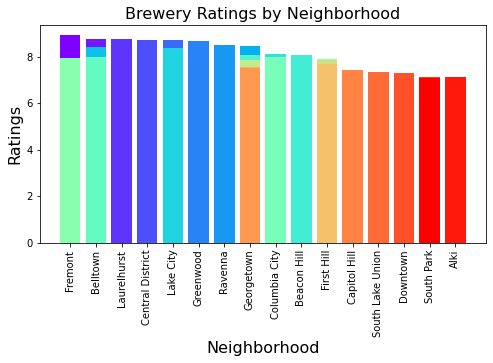

In [29]:
seattle_brew_stats_neigh = seattle_brew_stats
seattle_brew_stats_neigh=seattle_brew_stats_neigh.sort_values('Combined Rating',ascending=False)


x_ax = seattle_brew_stats_neigh['Neighborhood']
y_ax = seattle_brew_stats_neigh['Combined Rating']

colors = cm.rainbow(np.linspace(0, 1, len(seattle_brew_stats_neigh.index)))
plt.figure(figsize = (8, 4))
plt.xticks(rotation = 90)
plt.xlabel('Neighborhood', fontsize = 16)
plt.ylabel('Ratings', fontsize = 16)
plt.title('Brewery Ratings by Neighborhood', fontsize = 16)

plt.bar(x_ax, y_ax, color = colors)

### Graph the beer ratings by venue

<BarContainer object of 30 artists>

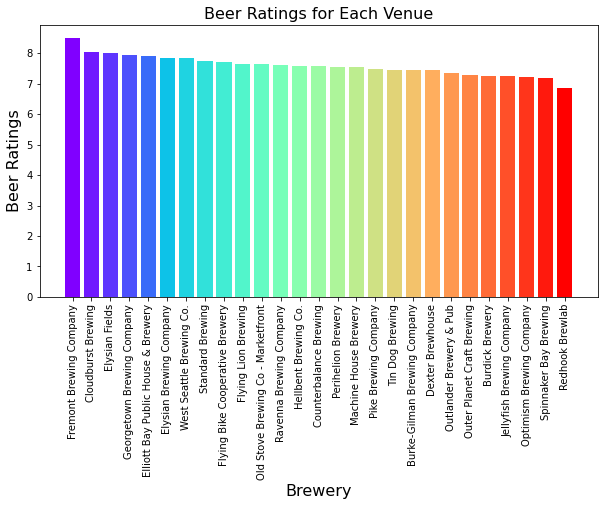

In [30]:
#Brewery Ratings by BA Beer Stats
seattle_brew_stats_beer = seattle_brew_stats
seattle_brew_stats_beer=seattle_brew_stats_beer.sort_values('Ba Rating Beer Stats', ascending=False)

x_ax = seattle_brew_stats_beer['Name']
y_ax = seattle_brew_stats_beer['Ba Rating Beer Stats']


colors = cm.rainbow(np.linspace(0, 1, len(seattle_brew_stats_beer.index)))
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
plt.xlabel('Brewery', fontsize = 16)
plt.ylabel('Beer Ratings', fontsize = 16)
plt.title('Beer Ratings for Each Venue', fontsize = 16)

plt.bar(x_ax, y_ax, color = colors)

### Graph the brewery ratings by venue

<BarContainer object of 30 artists>

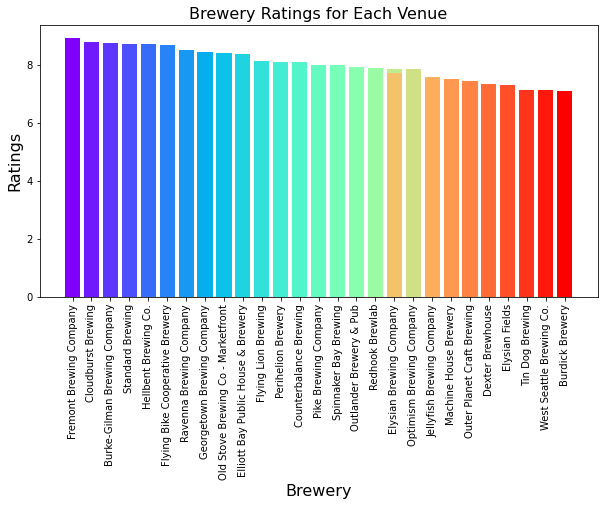

In [31]:
#Sort datafrme by ratings
seattle_brew_stats_rating = seattle_brew_stats
seattle_brew_stats_rating=seattle_brew_stats_rating.sort_values('Combined Rating', ascending=False)

x_ax = seattle_brew_stats_rating['Name']
y_ax = seattle_brew_stats_rating['Combined Rating']


colors = cm.rainbow(np.linspace(0, 1, len(seattle_brew_stats_rating.index)))
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
plt.xlabel('Brewery', fontsize = 16)
plt.ylabel('Ratings', fontsize = 16)
plt.title('Brewery Ratings for Each Venue', fontsize = 16)

plt.bar(x_ax, y_ax, color = colors)

### Graph the brewery like ratings by venue

<BarContainer object of 30 artists>

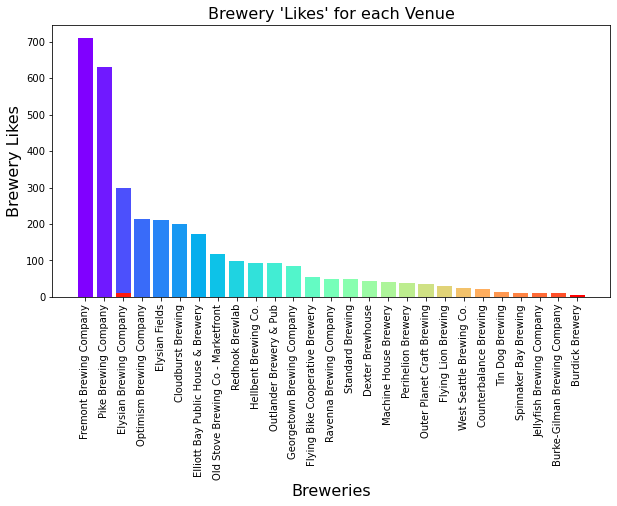

In [32]:
#Sort datafrme by likes
seattle_brew_stats_likes=seattle_brew_stats
seattle_brew_stats_likes=seattle_brew_stats_likes.sort_values('Likes', ascending=False)

x_ax = seattle_brew_stats_likes['Name']
y_ax = seattle_brew_stats_likes['Likes']


colors = cm.rainbow(np.linspace(0, 1, len(seattle_brew_stats_rating.index)))
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
plt.xlabel('Breweries', fontsize = 16)
plt.ylabel('Brewery Likes', fontsize = 16)
plt.title('Brewery \'Likes\' for each Venue', fontsize = 16)

plt.bar(x_ax, y_ax, color = colors)

### Graph the brewery tip ratings by venue

<BarContainer object of 30 artists>

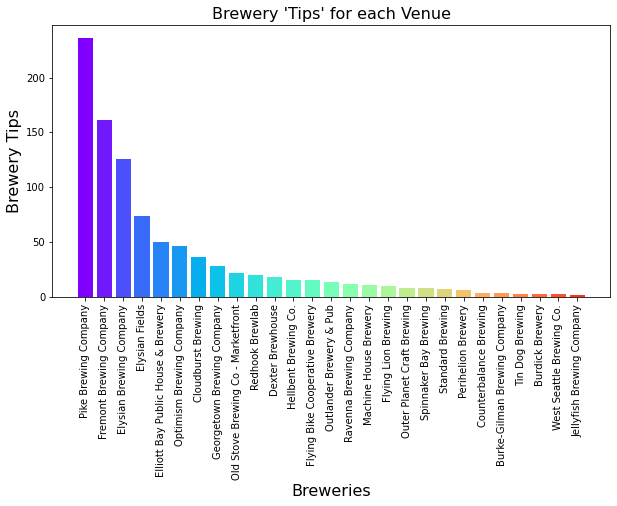

In [33]:
#Sort datafrme by ratings
seattle_brew_stats_tips = seattle_brew_stats
seattle_brew_stats_tips=seattle_brew_stats_tips.sort_values('Tips', ascending=False)

x_ax = seattle_brew_stats_tips['Name']
y_ax = seattle_brew_stats_tips['Tips']


colors = cm.rainbow(np.linspace(0, 1, len(seattle_brew_stats_tips.index)))
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
plt.xlabel('Breweries', fontsize = 16)
plt.ylabel('Brewery Tips', fontsize = 16)
plt.title('Brewery \'Tips\' for each Venue', fontsize = 16)
plt.bar(x_ax, y_ax, color = colors)

### Normalize the 'like' and 'tips' scale and add a weight to each feature scale; Add these as new columns in the dataframe

In [34]:
#Try to convert 'likes score' to be from 1 to 10 to try to combine and compare with 'Rating'

min,max = 0,10
x,y = seattle_brew_stats['Likes'].min(),seattle_brew_stats['Likes'].max()
seattle_brew_stats['Likes_Norm'] = (seattle_brew_stats['Likes']-x) / (y -x) * (max-min) + min

#min2, max2 = 0,10
a,b = seattle_brew_stats['Tips'].min(),seattle_brew_stats['Tips'].max()
seattle_brew_stats['Tips_Norm'] = (seattle_brew_stats['Tips']-a) / (b -a) * (max-min) + min

#Ratings were weighted with 3, likes by 0.5, and Tips by 1
seattle_brew_stats['Combined_Score'] = ((seattle_brew_stats['Ba Rating Beer Stats']*1.5)+seattle_brew_stats['Rating']+seattle_brew_stats['Ba Rating Place Stats']+(seattle_brew_stats['Likes_Norm'] /2 )+(seattle_brew_stats['Tips_Norm']/2))/4

seattle_brew_stats.head()

,ID,Neighborhood,Latitude,Longitude,Name,Likes,Rating,Tips,Ba Rating Beer Stats,Ba Rating Place Stats,Combined Rating,Likes_Norm,Tips_Norm,Combined_Score
0,54f8d7cd498e011cb93ae3c9,Belltown,47.61,-122.35,Cloudburst Brewing,199,9.1,36,8.04,8.42,8.76,2.751773,1.525424,7.929650
1,595c0cb5123a195de691c5ea,Belltown,47.61,-122.34,Old Stove Brewing Co - Marketfront,117,8.7,22,7.66,8.12,8.41,1.588652,0.932203,7.392607
2,40b13b00f964a520e1f61ee3,Belltown,47.61,-122.34,Pike Brewing Company,630,8.2,236,7.48,7.78,7.99,8.865248,10.000000,9.158156
3,53c1db29498eabb50501e673,Capitol Hill,47.62,-122.32,Outer Planet Craft Brewing,35,7.4,8,7.28,7.48,7.44,0.425532,0.338983,6.545564
4,5141334ce4b00f63c3fa2085,Central District,47.60,-122.30,Standard Brewing,48,8.5,7,7.76,8.90,8.70,0.609929,0.296610,7.373317


### Graph the brewery combined score for each venue

<BarContainer object of 30 artists>

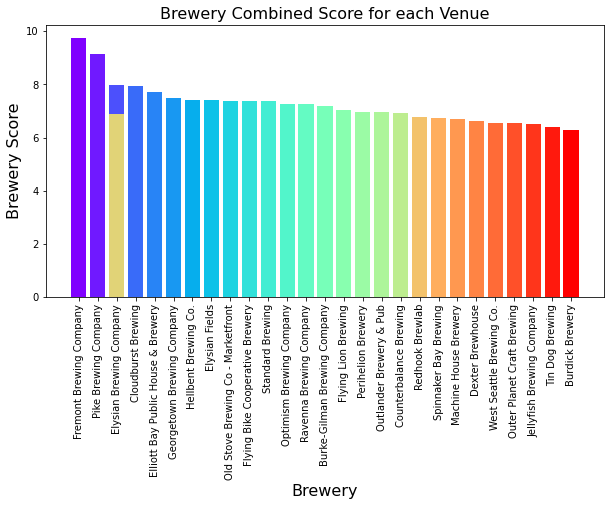

In [35]:
#Sort datafrme by combined rating bin
seattle_brew_stats_combined_rating=seattle_brew_stats
seattle_brew_stats_combined_rating=seattle_brew_stats_combined_rating.sort_values('Combined_Score', ascending=False)

x_ax = seattle_brew_stats_combined_rating['Name']
y_ax = seattle_brew_stats_combined_rating['Combined_Score']


colors = cm.rainbow(np.linspace(0, 1, len(seattle_brew_stats_combined_rating.index)))
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
plt.xlabel('Brewery', fontsize = 16)
plt.ylabel('Brewery Score', fontsize = 16)
plt.title('Brewery Combined Score for each Venue', fontsize = 16)

plt.bar(x_ax, y_ax, color = colors)

### Create a map of Seattle with breweries superimposed on top
#### Colored folium marker used to identify brewery rating:
low = red, 
okay = orange,
good = green,
very good = blue,
excellent = purple

In [36]:

labels = ['Good', 'Very good', 'Excellent']
seattle_brew_stats['rating_bin'] = pd.cut(seattle_brew_stats['Combined_Score'].astype(float), bins = 3, labels = labels, include_lowest = True)



In [37]:
color_map = {'Okay': 'orange', 'Good': 'green', 'Very good': 'blue', 'Excellent': 'purple'}

map_breweries = folium.Map(location=[latitude,longitude], zoom_start=10)  #Map of Seattle area

for lat, lon, name, rating_bin in zip(seattle_brew_stats['Latitude'],
                                      seattle_brew_stats['Longitude'],
                                      seattle_brew_stats['Name'],
                                      seattle_brew_stats['rating_bin']):
    
    label = '{}, {}'.format(name, rating_bin)
    label = folium.Popup(label, parse_html = True)
    
    folium.Marker(
        [lat, lon],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(map_breweries) 

 
    
map_breweries



### Import libraries for word cloud visualization

In [38]:
#!pip install wordcloud

In [39]:
import os

from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

### Import excel spreadsheet that includes brewery tips

In [40]:

brewery_tips = pd.read_excel (r'C:/Users/thayes/Documents/GitHub/projects/Coursera_Capstone/Seattle_Neighborhoods.xlsx', sheet_name='Brewing Tips')
print(brewery_tips.shape)
brewery_tips.head()


(20, 7)


,Fremont_Brewing_Tips,Cloudburst_Tips,Pikes_Tips,Elysian_Tips,Hellbent_Tips,Flying_Bike_Tips,Burke_Gilman_Tips
0,Free apples and pretzels. Bring your dog (ask ...,Excellent new brewery near the market. Beer on...,Try the beer sampler and grab a cup of the cra...,"If you like amazingly rich food, try the Steak...",Love this place and their beer selection. We r...,Very cool neighborhood place!!! They even have...,Outdoor seating with firepits is perfect for p...
1,One of the best breweries Seattle has to offer...,"Cool, young vibe. Lines are weird and bartende...",The crab chowder is to die for,The bratwurst is really amazing. All the combi...,Beautiful Outside Ptio. Food trucks every nigh...,Bring your dog's. Bring your kids. Bring your ...,This is as good as it gets for a craft beer ou...
2,"Yay, beer! There are community tables here so ...",Best beers we had on our trip to Seattle. Try ...,Great place to grab a beer while exploring Sea...,Try their standard craft brews. Signatures are...,"The ciders are excellent, as is the service. T...","Member-driven brewery with excellent, creative...",.
3,Great place just outside downtown Seattle; get...,These guys are making some of the better IPAs ...,Beer selection and decor are top notch,"Beer is great, anyone will find a suitable var...",One of the few breweries that do not allow kid...,Love the creative beer they got here! And love...,.
4,One of Seattle's most iconic family owned brew...,Very solid downtown brewery. Get an IPA if you...,"The Pike Pilsner was my favourite here, but no...",The steamed clams are a tad salty but delish n...,"All of their beers, enjoyed on their patio. Gr...",You can order smaller portions of beer and sam...,.


### Get text from all the reviews in our list

In [43]:
# Get text from all the reviews in our list
text_fremont = " ".join(review for review in brewery_tips.Fremont_Brewing_Tips)
text_cloudburst = " ".join(review for review in brewery_tips.Cloudburst_Tips)
text_pikes = " ".join(review for review in brewery_tips.Pikes_Tips)
text_elysian = " ".join(review for review in brewery_tips.Elysian_Tips)
text_hellbent = " ".join(review for review in brewery_tips.Hellbent_Tips)
text_flying_bike = " ".join(review for review in brewery_tips.Flying_Bike_Tips)
text_burke = " ".join(review for review in brewery_tips.Burke_Gilman_Tips)


### Create stop word list and append additional words as necessary

In [44]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "Seattle", "Breweries", "place", "One", 
                  "beer", "beers", "brewery", "really", "try", "Pike", "die",
                 "brew", "brews", "will", "come", "dry", "Fremont", "bring", "good", "order", "pandemic"])


### Create and generate a word cloud image:

In [45]:
fremont_brewing_wc = WordCloud(
    background_color='white',
    max_words=75,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_fremont)

cloudburst_brewing_wc = WordCloud(
    background_color='white',
    max_words=75,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_cloudburst)

pikes_brewing_wc = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_pikes)

elysian_brewing_wc = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_elysian)

hellbent_brewing_wc = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_hellbent)

flying_bike_wc = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_flying_bike)

burke_wc = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50,
    stopwords=stopwords,
    ).generate(text_burke)

### Plotting the word clouds

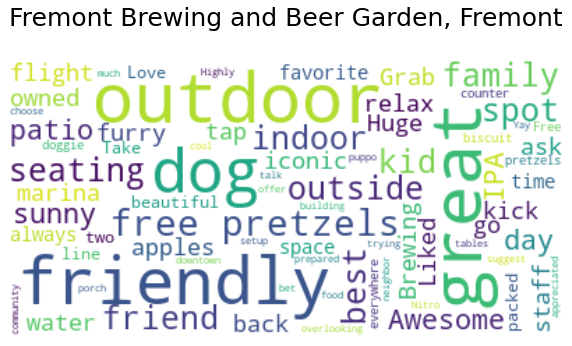

In [46]:
# Displaying the WordCloud  
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.axis('off')
plt.title('Fremont Brewing and Beer Garden, Fremont\n',fontsize=25)
plt.imshow(fremont_brewing_wc, interpolation='bilinear')

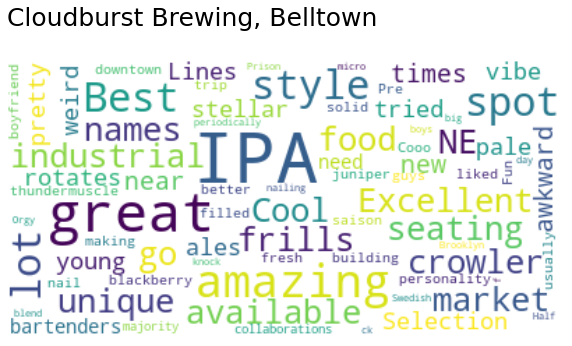

In [47]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.axis('off')
plt.title('Cloudburst Brewing, Belltown\n',fontsize=25,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(cloudburst_brewing_wc, interpolation='bilinear')

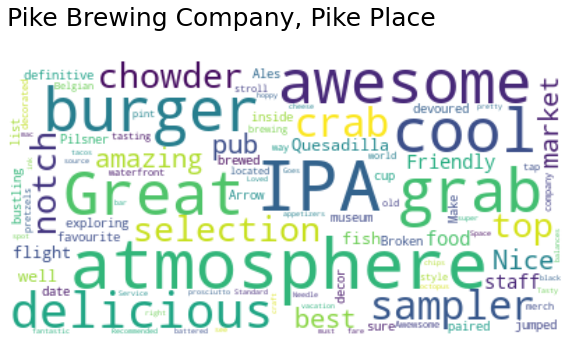

In [48]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.axis('off')
plt.title('Pike Brewing Company, Pike Place\n',fontsize=25,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(pikes_brewing_wc, interpolation='bilinear')


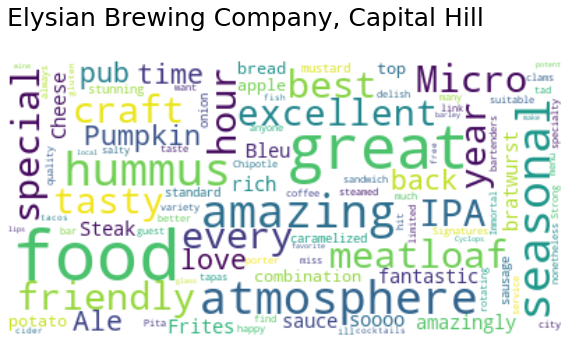

In [49]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.axis('off')
plt.title('Elysian Brewing Company, Capital Hill\n',fontsize=25,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(elysian_brewing_wc, interpolation='bilinear')

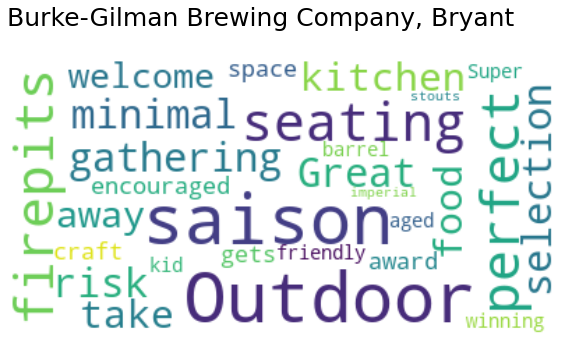

In [50]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.axis('off')
plt.title('Burke-Gilman Brewing Company, Bryant\n',fontsize=25,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burke_wc, interpolation='bilinear')

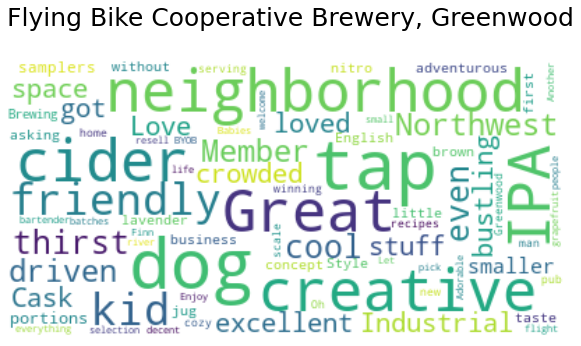

In [51]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.axis('off')
plt.title('Flying Bike Cooperative Brewery, Greenwood\n',fontsize=25,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(flying_bike_wc, interpolation='bilinear')

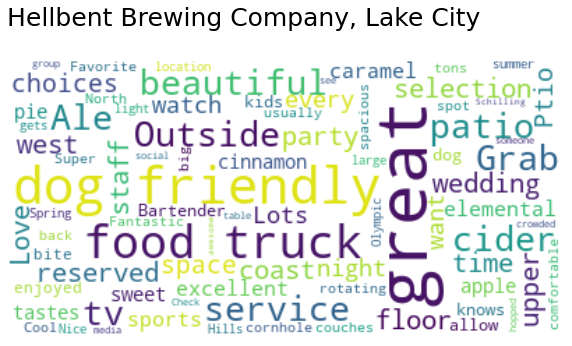

In [52]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10)
plt.axis('off')
plt.title('Hellbent Brewing Company, Lake City\n',fontsize=25,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(hellbent_brewing_wc, interpolation='bilinear')


### Now retrieve the 10 top words from each word cloud based on their frequency

In [53]:
wc1=pd.DataFrame(fremont_brewing_wc.words_,index=['']).transpose()
wc2=pd.DataFrame(cloudburst_brewing_wc.words_,index=['']).transpose()

wc3=pd.DataFrame(pikes_brewing_wc.words_,index=['']).transpose()
wc4=pd.DataFrame(elysian_brewing_wc.words_,index=['']).transpose()
wc5=pd.DataFrame(flying_bike_wc.words_,index=['']).transpose()
wc6=pd.DataFrame(burke_wc.words_,index=['']).transpose()

In [54]:
print('Fremont Brewing:\n',wc1.head(10),'\n''--------------------\n')
print('Cloudburst Brewing:\n',wc2.head(10),'\n''--------------------\n')
print('Pike Brewing:\n',wc3.head(10),'\n''--------------------\n')
print('Elysian Brewing:\n',wc4.head(10),'\n''--------------------\n')
print('Flying Bike:\n',wc5.head(10),'\n''--------------------\n')
print('Burke-Gilman Brewing:\n',wc6.head(10),'\n''--------------------\n')


Fremont Brewing:
                     
outdoor        1.000
great          1.000
friendly       0.875
dog            0.750
free pretzels  0.625
kid            0.500
seating        0.500
best           0.500
outside        0.500
family         0.500 
--------------------

Cloudburst Brewing:
               
IPA        1.0
great      0.6
amazing    0.4
spot       0.3
Best       0.3
style      0.3
lot        0.3
Excellent  0.2
market     0.2
food       0.2 
--------------------

Pike Brewing:
                 
IPA         1.00
atmosphere  1.00
grab        0.75
Great       0.75
burger      0.75
awesome     0.75
cool        0.75
delicious   0.75
sampler     0.50
crab        0.50 
--------------------

Elysian Brewing:
                  
food        1.000
great       0.750
amazing     0.375
hummus      0.375
seasonal    0.375
atmosphere  0.375
craft       0.250
best        0.250
meatloaf    0.250
every       0.250 
--------------------

Flying Bike:
                       
tap           1.00